Modelling a viscoelastic rheology with Underworld
=====

This tutorial is designed as an introduction to modelling viscoelastic materials using Underworld and includes basic theory, implementation, testing, geodynamic applications and published results.

**The Maxwell viscoelastic model**

Earth's interior behaves as a viscoelastic material, on short time scales it responds as an elastic solid while on long time scales the response as a viscous fluid. The Maxwell viscoelastic model can be considered appropriate for Earth's interior, producing strain rates proportional to the sum of the stress and stress rate. As such, the strain rate, $D_{ij}$, is given by  

$$ D_{ij} = D^v_{ij} + D^e_{ij} = \frac{\tau_{ij}}{2\eta} + \frac{\dot\tau_{ij}}{2\mu} $$

where $v$ and $e$ signify the respective viscous and elastic components of the strain rate, $\tau$ is the stress, $\eta$ the shear viscosity, $\mu$ the elastic shear modulus with $\dot\tau$ the stress tensors time derivative, 

$$ \dot\tau =  \lim_{x \rightarrow 0} \frac{\tau(t,x)-\tau(t-\delta t, x)}{\delta t}$$

**The momentum equation for a viscoelastic rheology**

Writing $\dot\tau$ as a finite difference, substituting into the strain rate equation above and solving for $\tau$ gives,

$$\tau_{ij}(t,x) = 2\eta_{eff}D_{ij}(t,x) + \frac{\eta_{eff}}{\mu\Delta t}\check{\tau}(t-\Delta t, x) $$

where $\eta_{eff} = ( \eta \Delta t) / (\alpha + \Delta t)$ is an effective viscosity, $\alpha = \eta / \mu$ the Maxwell relaxation time, and $\check{\tau}$ is the stress history advectived and rotated into the current reference frame using the velocity field $\bf{u}$, discussed further tutorial 020. Substituting this viscoelastic stress definition into the conservation of momentum equation, defined as

$$ \sigma_{ij,j} = \tau_{ij,j} - p_i = f_i $$

where $\sigma$ is the total stress tensor, $p$ the isotropic pressure and $f$ the force term, gives

$$ ( 2 \eta_{eff} D_{ij} )_{,j} - p_{,i} = f_i - \frac{\eta_{eff}}{\mu\Delta t}\check{\tau}_{ij,j} $$

Thus, our implementation of viscosity elasticity, after [Moresi et al, 2003](http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1), modifies the momentum equation using an effective viscosity and additional force term dependent on material properties, time step size and stress history. The above viscoelastic momentum equation coupled with convervation of mass, $ u_{i,j}$ provides a solution for a Maxwell viscoelastic material deforming under the Boussinesq approximation for infiniti Prandtl, low Reynolds number incompressible flow. 

**The observation time step**

An interesting consequence of this implementation is the force terms dependence on time step. A decoupling of this time scale and the numeric time scale is requied to provide the modeller control over the time scale of interest. If this is not allowed the dynamics of the model would be a direct response to, for example, the chosen grid resolution via the courant factor. To overcome this, an observation time step, $\Delta t_e$ is introduced, ensuring the time scale of interest is resolved, distict from the numeric time step, $\Delta t_c$. This has been acheived by introducing $T$, the stress history term defined across $n$ numerical time steps of size $\Delta t_c$. Stress at the current time $t$ is then defined as

$$ \tau_{ij}(t) = 2 \eta_{eff} D_ij(t) + \frac{\eta_{eff}}{\mu\Delta t_e} \tilde{T}(\check{\tau}^{t-\Delta t_e}_{ij}) $$

The numeric time step is capped to ensure stresses are resolved with the observation time. A consequence of this implementation is that the stress history tensor must be stored for longer than one time step, leading to potential memory issues.  To overcome this, the stress history term is stored as a running average, defined as

$$ T^t_{ij} = ( 1 - \Phi) \tilde{T}(T^{t-\Delta t_c}_{ij}) + \Phi\tau^t_{ij} $$

where $\Phi = \Delta t_c / \Delta t_e < 1$.



See [Farrington et al (2014)](http://onlinelibrary.wiley.com/doi/10.1002/2014GC005507/abstract) for full details.

**References**

Farrington, R. J., L.-N. Moresi, and F. A. Capitanio (2014), The role of viscoelasticity in subducting plates, Geochem. Geophys. Geosyst., 15, 4291–4304, http://onlinelibrary.wiley.com/doi/10.1002/2014GC005507/abstract.

Moresi, L., Dufour, F., & Mühlhaus, H. B. (2003). A Lagrangian integration point finite element method for large deformation modeling of viscoelastic geomaterials. Journal of Computational Physics, 184(2), 476-497. http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1



**A viscoelastic cantilever beam**

An intuitive, first example of a viscoelastic material is that of a loaded cantilever beam. A purely elastic cantilever beam will deform under loading, and recover completely when the load is removed.  Conversely, a purely viscous beam with remain deformed when the load is removed. For a viscoelastic material during loading, stress is both dissipated (viscous) and stored (elastic), when the load is removed only the stored stress is recovered. A viscoelastic cantilever beam partially returns to its initial position. 

In [1]:
# define background material properties
eta_bg     = 1.0e-2
density_bg = 0.0

# define beam material properties
density = 1.
eta     = 1.0e2  # viscosity
mu      = 1.0e1 # elastic modulus
dt_e    = 1.0  # observation time

alpha   = eta / mu                         # viscoelastic relaxation time
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

print "Maxwell relaxation time = ", alpha
print "effective viscosity = ", eta_eff

Maxwell relaxation time =  10.0
effective viscosity =  9.09090909091


In [2]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np

In [3]:
# Create mesh
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (32, 32), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) ) 

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [4]:
# Apply velocity boundary conditions
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
leftWall = mesh.specialSets["MinI_VertexSet"]

# no slip on left wall, free slip on all others
cantileverBC = uw.conditions.DirichletCondition( variable       = velocityField, 
                                            indexSetsPerDof = ( iWalls, jWalls+leftWall) ) 

In [5]:
# create swarm
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# add swarm variable
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

# add previous stress swarm variable to carry the stress history term
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]

# create tracer particle within beam
tracerSwarm = uw.swarm.Swarm( mesh=mesh )
tracerSwarm.add_particles_with_coordinates(np.array([(0.79,0.75)]))

array([0], dtype=int32)

In [6]:
# layout materials
background  = 0
beam        = 1

coord = fn.input()
conditions = [ (  (coord[1] > 0.7) 
                & (coord[1] < 0.8) 
                & (coord[0] < 0.8), beam),
               (             True , background ),
             ]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)


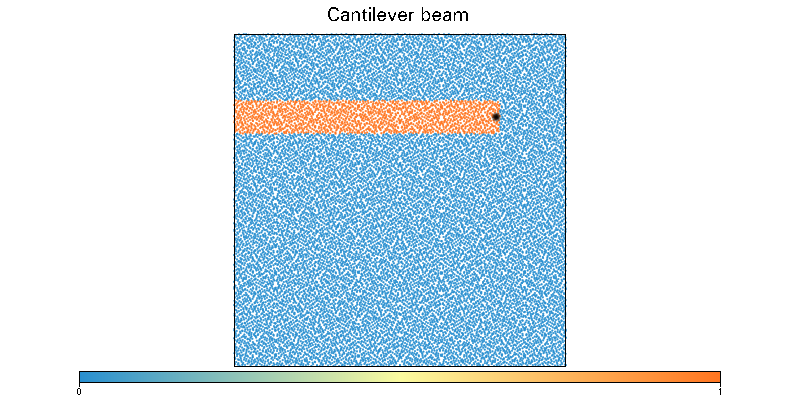

In [7]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Cantilever beam" )
figMaterial.append( glucifer.objects.Points(tracerSwarm, pointSize=10.0) )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=3.0) )
figMaterial.show()

In [8]:
# map viscosity to material
mappingDictViscosity = { background : eta_bg, 
                               beam : eta }
viscosityMapFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictViscosity )

In [9]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

In [10]:
# define the viscoelastic stress tensor
viscousStressFn       = 2. * viscosityMapFn * strainRate 
elasticStressFn       = eta_eff / ( mu * dt_e ) * previousStress
viscoelasticeStressFn = viscousStressFn + elasticStressFn

# map stress tensor material type
mappingDictStress = { background : viscousStressFn, 
                      beam       : viscoelasticeStressFn }
stressFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictStress )

In [11]:
# density
mappingDictDensity = { background : density_bg,
                             beam : density }
densityFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictDensity )

# buoyancy force term
gravity = 1.
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityFn * gravity * z_hat

In [12]:
# set psuedo compressibility for background material
mappingDictLamdba = { background : 10.,
                            beam : 0. }
lambdaFn = fn.branching.map( fn_key=materialIndex, mapping=mappingDictLamdba )

In [13]:
# create stokes system, solver and advector
stokes = uw.systems.Stokes( velocityField    = velocityField, 
                           pressureField     = pressureField,
                           voronoi_swarm     = swarm, 
                           conditions        = [cantileverBC,],
                           fn_viscosity      = viscosityMapFn, 
                           fn_bodyforce      = buoyancyFn,
                           fn_one_on_lambda  = lambdaFn,        # include psuedo compressibility for background
                           _fn_stresshistory = elasticStressFn) # include viscoelastic stress history 

solver = uw.systems.Solver( stokes )

advector       = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
tracerAdvector = uw.systems.SwarmAdvector( swarm=tracerSwarm, velocityField=velocityField, order=2 )

In [14]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()

    # ensure elastic stresses are resolved on the time scale of interest
    # by capping time step to 1/3 of the observation time 
    if dt > ( dt_e / 3. ):
        dt = dt_e / 3.  
    
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)

    # save stress to be transported with particle
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )

    # Advect particles
    advector.integrate(dt)
    tracerAdvector.integrate(dt)
    
    return time+dt, step+1

In [15]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

deflection = tracerSwarm.particleCoordinates.data[0][1]

In [16]:
# load beam until y = 0.4
while deflection > 0.4 :
    # solve stokes problem
    solver.solve()          
    # update.
    time, step = update()
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    if step%10 == 0:            
        print step, time, deflection

10 2.21813715614 0.602207074244
20 5.55147048947 0.500906960503
30 8.8848038228 0.440622936001



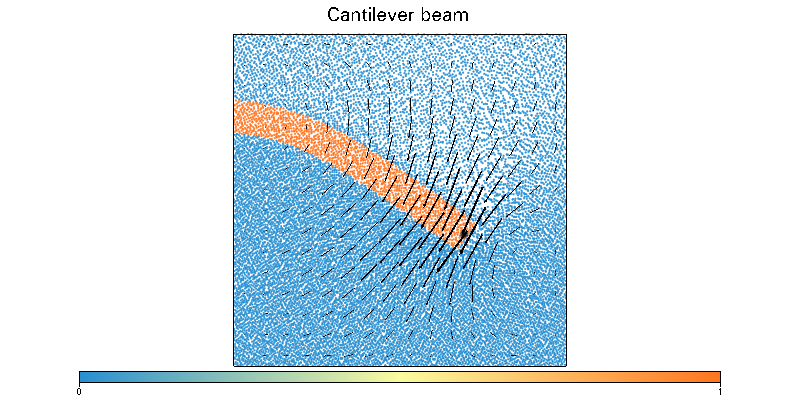

In [17]:
figMaterial.append( glucifer.objects.VectorArrows(mesh, velocityField*10.))
figMaterial.show()

In [18]:
# re-build stokes - turn off buoyancy
stokesNew = uw.systems.Stokes( velocityField    = velocityField, 
                           pressureField     = pressureField,
                           voronoi_swarm     = swarm, 
                           conditions        = [cantileverBC,],
                           fn_viscosity      = viscosityMapFn, 
                           fn_bodyforce      = None,
                           fn_one_on_lambda  = lambdaFn, 
                           _fn_stresshistory = elasticStressFn)
solverNew = uw.systems.Solver( stokesNew )

In [19]:
# allow elastic stresses to relax for 10 steps
nsteps = step+10
while step < nsteps:
    # solve stokes problem
    solverNew.solve()          
    # update.
    time, step = update()
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    if step%10 == 0:            
        print step, time, deflection

40 12.0616910355 0.408838603823



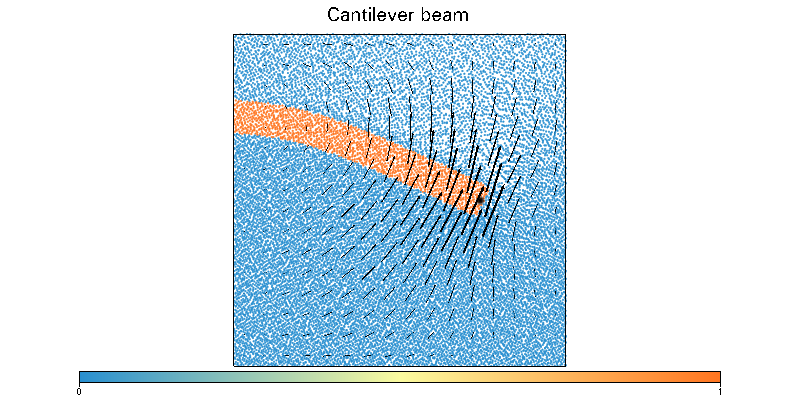

In [20]:
figMaterial.show()

In [21]:
# allow elastic stresses to relax further
while step < 100:
    # solve stokes problem
    solverNew.solve()          
    # update.
    time, step = update()
    deflection = tracerSwarm.particleCoordinates.data[0][1]

    if step%10 == 0:            
        print step, time, deflection

50 15.131589848 0.502753469688
60 18.4649231813 0.524255159978
70 21.7982565146 0.52896149249
80 25.131589848 0.529980043512
90 28.4649231813 0.53019204946
100 31.7982565146 0.530236374239



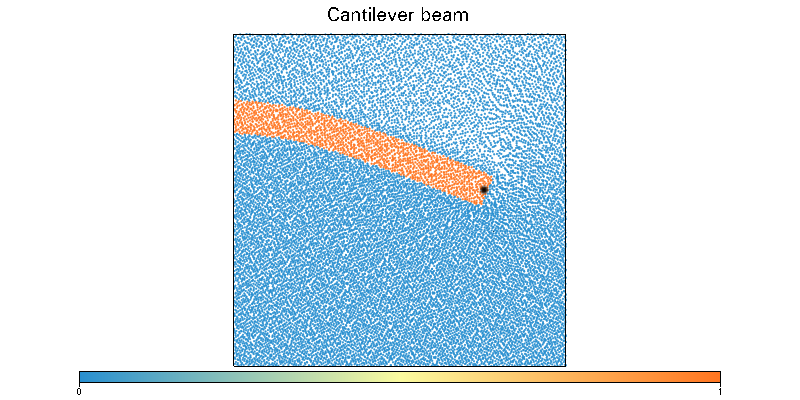

In [22]:
figMaterial.show()

**The remaining notebooks in this tutorial will contain**

020 - Analytic solutions in Underworld 
    - solve for a simple shear in 2D
    - discuss the importance of the time scale
    - include discussion regarding tensor invariance, rotation, jaumann, etc.
    - include a 3D rotated shearing solution
    
030 - Viscoelastic stresses in subduction
    - outline problem and results from Farrington (2014)
    
040 - Viscoelastic plate loading
    - outline test case, what do we expect
    - what is the result?
    
050 - Viscoelastic beam in extension
    - viscoelastoplastic implementation
    - reproduction of Moresi et al (2003), Figure 8.
    
060 - Viscoelastoplastic material in extentional settings
    - Discuss rifting with a viscoelastoplastic rheology
  